In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
from folium import plugins
from folium.plugins import MarkerCluster

print('Libraries imported.')

Libraries imported.


### Find all neighborhoods lat/long in Brooklyn 

In [2]:
# Reading new york data 
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

# Define the dataframe columns
column_names = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude']

neighborhoods_data = newyork_data['features']

# Instantiatte the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

# Looping through the data and fill the dataframe one row at a time 
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough']
    neighborhood_name = data['properties']['name']
    
    neighborhood_latlng = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlng[1]
    neighborhood_lng = neighborhood_latlng[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                         'Neighbourhood': neighborhood_name,
                                         'Latitude': neighborhood_lat,
                                         'Longitude': neighborhood_lng}, ignore_index=True)

neighborhoods.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [3]:
brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
brooklyn_data.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


In [4]:
# Check number of neighborhoods in Brooklyn
brooklyn_data['Neighbourhood'].nunique()

70

### Get coordinates of Brooklyn

In [5]:
# Loading Foursquare credentials 
import yaml

with open("config.yaml", 'r') as yamlfile:
    cfg = yaml.safe_load(yamlfile)

CLIENT_ID = cfg['foursquare_creds']['YOUR_ID'] # your Foursquare ID
CLIENT_SECRET = cfg['foursquare_creds']['YOUR_SECRET'] # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
radius = 500 # define radius

In [6]:
# Coordinates of Brooklyn
address = 'Brooklyn, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Brooklyn are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Brooklyn are 40.6501038, -73.9495823.


Query 'food' category only 

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):

        food_category = '4d4b7105d754a06374d81259'

        # Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            food_category,
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
            
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                            'Neighbourhood Latitude', 
                            'Neighbourhood Longitude', 
                            'Venue', 
                            'Venue Latitude', 
                            'Venue Longitude',
                            'Venue Category']
    
    return(nearby_venues)

In [8]:
brooklyn_venues = getNearbyVenues(names=brooklyn_data['Neighbourhood'],
                                latitudes=brooklyn_data['Latitude'],
                                longitudes=brooklyn_data['Longitude'])


In [9]:
brooklyn_venues.shape

(2153, 7)

In [10]:
# Check total number of venues 
len(brooklyn_venues['Venue Category'].unique())

96

In [11]:
brooklyn_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Bath Beach,42,42,42,42,42,42
Bay Ridge,74,74,74,74,74,74
Bedford Stuyvesant,18,18,18,18,18,18
Bensonhurst,32,32,32,32,32,32
Bergen Beach,5,5,5,5,5,5
Boerum Hill,68,68,68,68,68,68
Borough Park,22,22,22,22,22,22
Brighton Beach,34,34,34,34,34,34
Broadway Junction,18,18,18,18,18,18


In [12]:
brooklyn_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
1,Bay Ridge,40.625801,-74.030621,Leo's Casa Calamari,40.624200,-74.030931,Pizza Place
2,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot
3,Bay Ridge,40.625801,-74.030621,Ho' Brah Taco Joint,40.622960,-74.031371,Taco Place
4,Bay Ridge,40.625801,-74.030621,Georgian Dream Cafe and Bakery,40.625586,-74.030196,Caucasian Restaurant


In [13]:
brooklyn_venues['Neighbourhood'].nunique()

69

In [14]:
brooklyn_venues['Venue'].nunique()

1774

### Find all listings in Brooklyn 

In [15]:
df_listings = pd.read_csv('listings.csv', low_memory=False, verbose=1)
df_listings.head()

Tokenization took: 179.24 ms
Type conversion took: 85.08 ms
Parser memory cleanup took: 2.53 ms


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,175,30,48,2019-11-04,0.36,2,365
1,3831,"Whole flr w/private bdrm, bath & kitchen(pls r...",4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,74,1,375,2020-11-22,4.97,1,307
2,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,30,50,2019-12-02,0.36,1,365
3,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Midtown,40.76468,-73.98315,Private room,65,2,474,2020-09-25,3.36,1,0
4,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,75,2,118,2017-07-21,0.86,1,0


In [16]:
# Create a dataframe for analysis 
listings_data = df_listings[['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price']]
listings_data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price
0,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,175
1,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,74
2,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60
3,Manhattan,Midtown,40.76468,-73.98315,Private room,65
4,Manhattan,Upper West Side,40.80178,-73.96723,Private room,75


In [17]:
# Select only entire home/apt room type
listings_conds = listings_data[(listings_data['room_type'] == 'Entire home/apt') & (listings_data['price'] <= 70) & (listings_data['neighbourhood_group'] == 'Brooklyn')].reset_index(drop=True)

listings_conds.rename(columns={'neighbourhood_group': 'Borough', 
                              'neighbourhood': 'Neighbourhood',
                              'latitude': 'Listing Latitude',
                              'longitude': 'Listing Longitude',
                             'room_type': 'Room Type',
                             'price': 'Price'}, inplace=True)

listings_conds.head()

,Borough,Neighbourhood,Listing Latitude,Listing Longitude,Room Type,Price
0,Brooklyn,Williamsburg,40.71492,-73.96282,Entire home/apt,70
1,Brooklyn,Park Slope,40.67542,-73.98142,Entire home/apt,69
2,Brooklyn,Bedford-Stuyvesant,40.68101,-73.94081,Entire home/apt,65
3,Brooklyn,Prospect-Lefferts Gardens,40.66068,-73.96003,Entire home/apt,50
4,Brooklyn,Bushwick,40.70642,-73.91665,Entire home/apt,68


In [18]:
listings_conds.shape

(423, 6)

In [19]:
listings_conds['Neighbourhood'].nunique()

38

In [20]:
listings_conds.duplicated().sum()

0

### Merge venues and listings dataframe by neighborhood

In [21]:
# merge on neighborhoods
merged_df = listings_conds.merge(brooklyn_venues, on='Neighbourhood', how='inner')

# drop borough column 
merged_df.drop(['Borough'], axis=1, inplace=True)

merged_df.head()

,Neighbourhood,Listing Latitude,Listing Longitude,Room Type,Price,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Williamsburg,40.71492,-73.96282,Entire home/apt,70,40.707144,-73.958115,Mexico 2000,40.707552,-73.955052,Taco Place
1,Williamsburg,40.71492,-73.96282,Entire home/apt,70,40.707144,-73.958115,Shalom Japan,40.709219,-73.955839,Japanese Restaurant
2,Williamsburg,40.71492,-73.96282,Entire home/apt,70,40.707144,-73.958115,Traif,40.710557,-73.958895,Tapas Restaurant
3,Williamsburg,40.71492,-73.96282,Entire home/apt,70,40.707144,-73.958115,Reben Luncheonette,40.708944,-73.959197,Breakfast Spot
4,Williamsburg,40.71492,-73.96282,Entire home/apt,70,40.707144,-73.958115,Xixa,40.710410,-73.958531,Latin American Restaurant


In [22]:
merged_df.shape

(10340, 11)

In [23]:
merged_df.duplicated().sum()

0

### Analyze nearby venues

In [24]:
merged_df['Venue Category'].nunique()

85

In [25]:
merged_df['Venue'].nunique()

1110

In [26]:
merged_df['Neighbourhood'].nunique()

35

In [27]:
# One hot encoding
brooklyn_onehot = pd.get_dummies(merged_df[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
brooklyn_onehot['Neighbourhood'] = merged_df['Neighbourhood']

# Move neighborhood column to the first column
fixed_columns = [brooklyn_onehot.columns[-1]] + list(brooklyn_onehot.columns[:-1])
brooklyn_onehot = brooklyn_onehot[fixed_columns]

In [28]:
brooklyn_onehot.head()

,Neighbourhood,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Chinese Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Greek Restaurant,Halal Restaurant,Hot Dog Joint,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Peruvian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shabu-Shabu Restaurant,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Williamsburg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,Williamsburg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Williamsburg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,Williamsburg,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Williamsburg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
brooklyn_onehot.shape

(10340, 86)

In [30]:
brooklyn_onehot['Neighbourhood'].nunique()

35

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return(row_categories_sorted.index.values[0:num_top_venues])

In [32]:
# Grouping each venue category by neighborhood 
# taking mean of the frequency of occurrence of each category
brooklyn_grouped = brooklyn_onehot.groupby('Neighbourhood').mean().reset_index()

num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Neighbourhood']
for idx in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most common venue'.format(idx+1, indicators[idx]))
    except:
        columns.append('{}th Most common venue'.format(idx+1))
        
# Create a new dataframe 
hoods_venues_sorted = pd.DataFrame(columns=columns)
hoods_venues_sorted['Neighbourhood'] = brooklyn_grouped['Neighbourhood']

for idx in np.arange(brooklyn_grouped.shape[0]):
    hoods_venues_sorted.iloc[idx, 1:] = return_most_common_venues(brooklyn_grouped.iloc[idx, :], num_top_venues)

hoods_venues_sorted.head()

,Neighbourhood,1st Most common venue,2nd Most common venue,3rd Most common venue
0,Bay Ridge,Pizza Place,Italian Restaurant,Chinese Restaurant
1,Bensonhurst,Chinese Restaurant,Pizza Place,Italian Restaurant
2,Bergen Beach,Café,Moroccan Restaurant,Restaurant
3,Boerum Hill,Deli / Bodega,Sandwich Place,Pizza Place
4,Borough Park,Pizza Place,Café,Fast Food Restaurant


In [33]:
hoods_venues_sorted['Neighbourhood'].nunique()

35

In [34]:
# set number of clusters
kclusters = 5

brooklyn_grouped_clustering = brooklyn_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=25, n_init=10).fit(brooklyn_grouped_clustering)

# cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 4, 1, 1, 1, 1, 1, 2, 1])

In [35]:
# create df of listings lat/lng only
listings = listings_conds[['Neighbourhood', 'Listing Latitude', 'Listing Longitude']]
listings.head()

,Neighbourhood,Listing Latitude,Listing Longitude
0,Williamsburg,40.71492,-73.96282
1,Park Slope,40.67542,-73.98142
2,Bedford-Stuyvesant,40.68101,-73.94081
3,Prospect-Lefferts Gardens,40.66068,-73.96003
4,Bushwick,40.70642,-73.91665


In [36]:
listings.shape

(423, 3)

In [37]:
listings.duplicated().sum()

0

In [38]:
# add clustering labels
hoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge listings and clusters
brooklyn_merged = listings

# merge data to add latitude/longitude for each neighborhood
brooklyn_merged = brooklyn_merged.join(hoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

brooklyn_merged.head() 

,Neighbourhood,Listing Latitude,Listing Longitude,Cluster Labels,1st Most common venue,2nd Most common venue,3rd Most common venue
0,Williamsburg,40.71492,-73.96282,1.0,Deli / Bodega,Pizza Place,Latin American Restaurant
1,Park Slope,40.67542,-73.98142,1.0,Pizza Place,Italian Restaurant,Burger Joint
2,Bedford-Stuyvesant,40.68101,-73.94081,NaN,NaN,NaN,NaN
3,Prospect-Lefferts Gardens,40.66068,-73.96003,NaN,NaN,NaN,NaN
4,Bushwick,40.70642,-73.91665,1.0,Deli / Bodega,Mexican Restaurant,Pizza Place


In [39]:
brooklyn_merged.shape

(423, 7)

In [40]:
brooklyn_merged=brooklyn_merged.dropna()
brooklyn_merged.shape

(323, 7)

In [41]:
brooklyn_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323 entries, 0 to 422
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Neighbourhood          323 non-null    object 
 1   Listing Latitude       323 non-null    float64
 2   Listing Longitude      323 non-null    float64
 3   Cluster Labels         323 non-null    float64
 4   1st Most common venue  323 non-null    object 
 5   2nd Most common venue  323 non-null    object 
 6   3rd Most common venue  323 non-null    object 
dtypes: float64(3), object(4)
memory usage: 20.2+ KB


In [42]:
brooklyn_merged = brooklyn_merged.astype({'Cluster Labels': 'int32'})
brooklyn_merged.head() 

,Neighbourhood,Listing Latitude,Listing Longitude,Cluster Labels,1st Most common venue,2nd Most common venue,3rd Most common venue
0,Williamsburg,40.71492,-73.96282,1,Deli / Bodega,Pizza Place,Latin American Restaurant
1,Park Slope,40.67542,-73.98142,1,Pizza Place,Italian Restaurant,Burger Joint
4,Bushwick,40.70642,-73.91665,1,Deli / Bodega,Mexican Restaurant,Pizza Place
5,Sunset Park,40.64372,-74.02066,1,Bakery,Latin American Restaurant,Deli / Bodega
6,Park Slope,40.67407,-73.98111,1,Pizza Place,Italian Restaurant,Burger Joint


### Create map of nearby venues 

In [43]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(brooklyn_merged['Listing Latitude'], brooklyn_merged['Listing Longitude'], brooklyn_merged['Neighbourhood'], brooklyn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine clusters

In [44]:
def venue_category_plot(col):
    plt.figure(figsize=(8,6))
    data=df[col].value_counts()
    sns.barplot(x=data.values, y=data.index,  data=df)
    plt.title('List of {}'.format(col), fontsize=14)
    plt.xlabel('Number of venues', fontsize=13)
    plt.xticks(rotation=0)
    plt.show

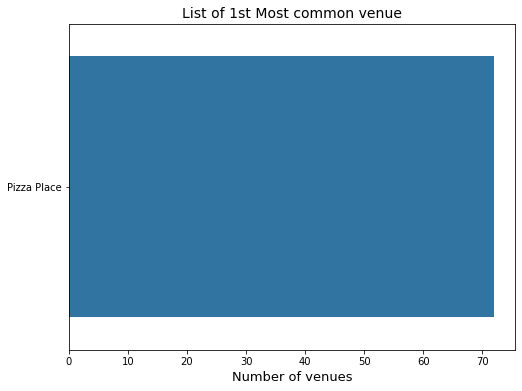

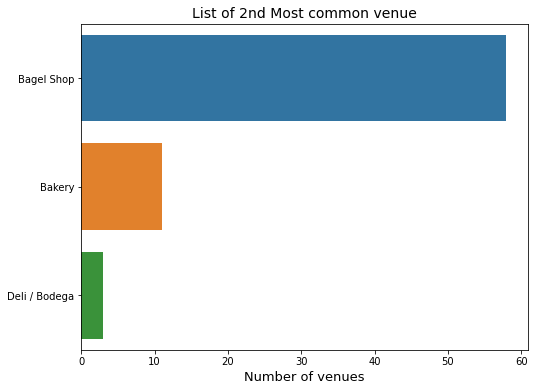

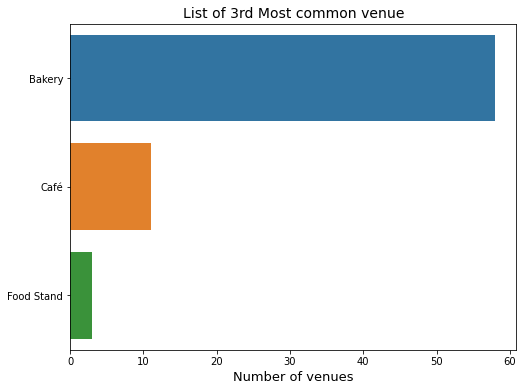

In [45]:
# cluster 0
brook1 = brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 0, brooklyn_merged.columns[[1] + list(range(4, brooklyn_merged.shape[1]))]]
df = brook1
for col in df.loc[:, '1st Most common venue':]:
    venue_category_plot(col)

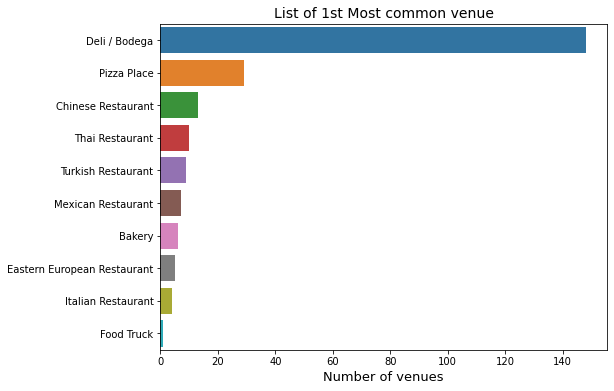

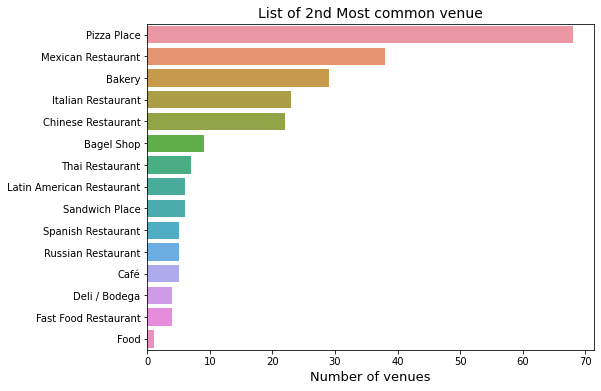

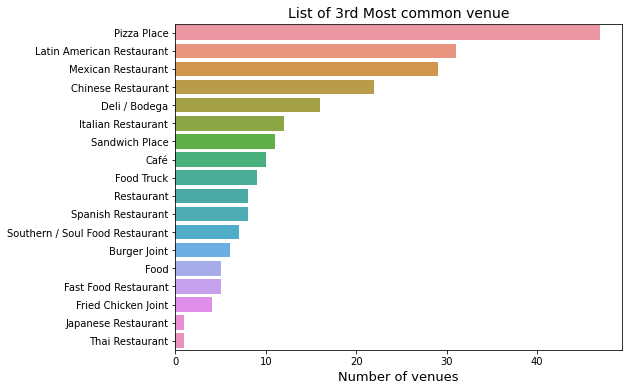

In [46]:
# cluster 1
brook2 = brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 1, brooklyn_merged.columns[[1] + list(range(4, brooklyn_merged.shape[1]))]]
df = brook2
for col in df.loc[:, '1st Most common venue':]:
    venue_category_plot(col)


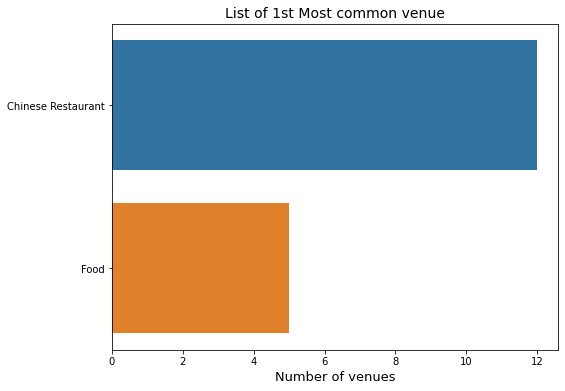

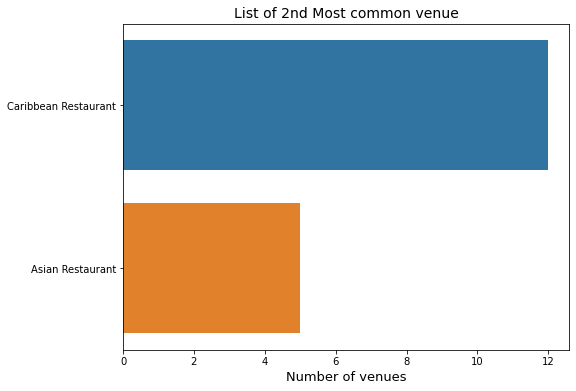

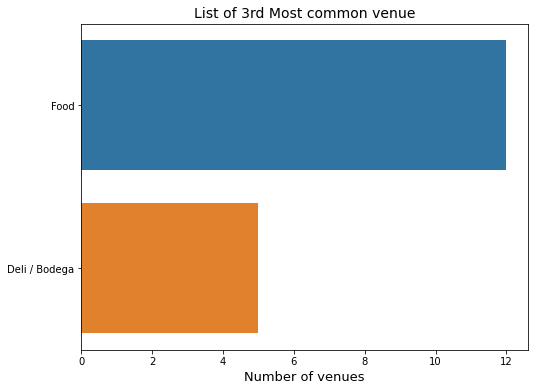

In [47]:
# cluster 2
brook3 = brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 2, brooklyn_merged.columns[[1] + list(range(4, brooklyn_merged.shape[1]))]]
df = brook3
for col in df.loc[:, '1st Most common venue':]:
    venue_category_plot(col)

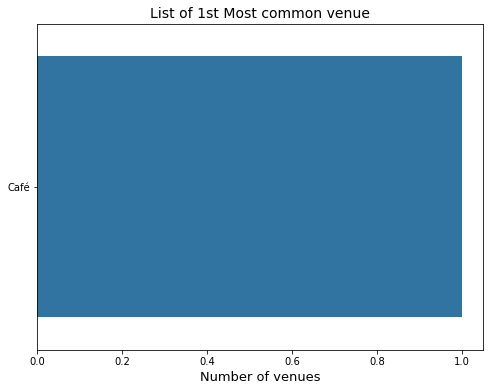

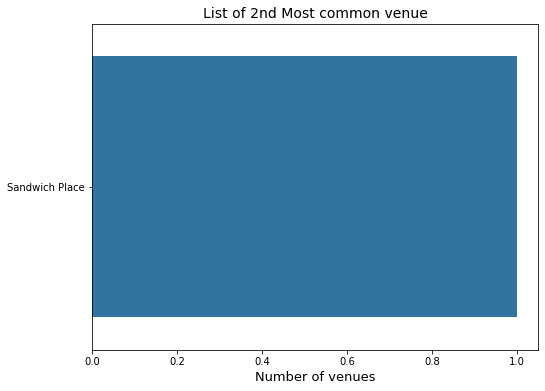

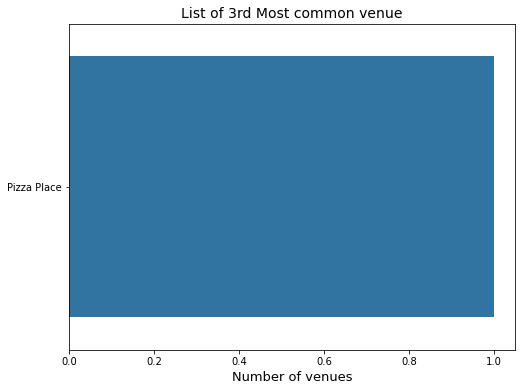

In [48]:
# cluster 3
brook4 = brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 3, brooklyn_merged.columns[[1] + list(range(4, brooklyn_merged.shape[1]))]]
df = brook4
for col in df.loc[:, '1st Most common venue':]:
    venue_category_plot(col)

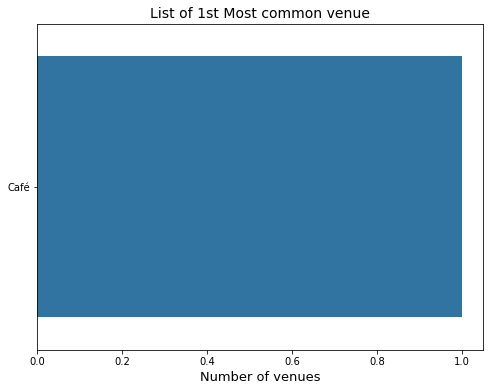

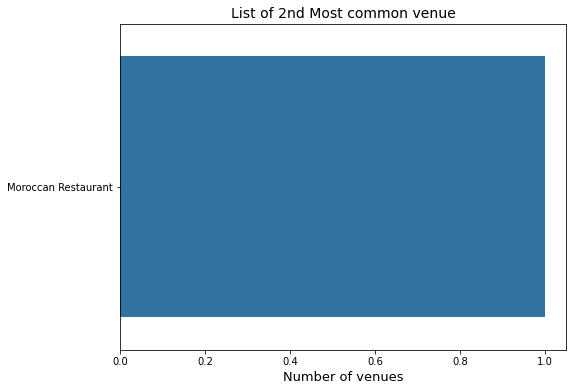

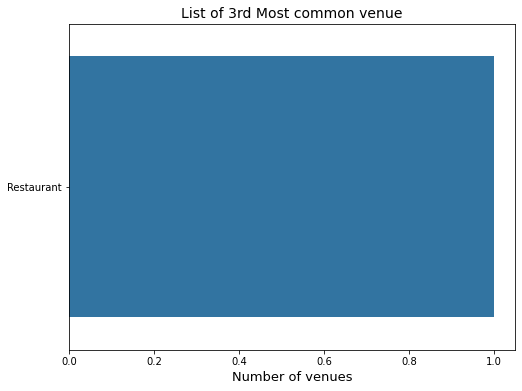

In [49]:
# cluster 4
brook5 = brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 4, brooklyn_merged.columns[[1] + list(range(4, brooklyn_merged.shape[1]))]]
df = brook5
for col in df.loc[:, '1st Most common venue':]:
    venue_category_plot(col)

### Pick cluster 1, create map of all listings in cluster 1

In [51]:
# create map
map_listings = folium.Map(location=[brooklyn_merged['Listing Latitude'].mean(), 
                          brooklyn_merged['Listing Longitude'].mean()], zoom_start=12)

# show only listings in cluster 4
df_lists = brooklyn_merged[brooklyn_merged['Cluster Labels'] == 1]

# create list of listings location
locate = df_lists[['Listing Latitude', 'Listing Longitude']]
locate_list = locate.values.tolist()

mc = MarkerCluster()

for row in range(0, len(locate_list)):
    mc.add_child(folium.Marker(location=locate_list[row], popup='Here we go'))
    
map_listings.add_child(mc)
map_listings